# Прогноз вероятности оттока пользователей для фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.   
А именно:   
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента   
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства   
- проанализировать основные признаки, наиболее сильно влияющие на отток   
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:   
   1) выделить целевые группы клиентов   
   2) предложить меры по снижению оттока   
   3) определить другие особенности взаимодействия с клиентами

## План прогноза вероятности:   <a class="anchor" id="0-bullet">   
[1. Загрузим данные и изучим общую информацию](#open)   
    
[2. Проведем исследовательский анализ данных](#eda)      
    
- Посмотрим на датасет: есть ли в нем отсутствующие признаки   
- Изучим средние значения и стандартные отклонения
- Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался   
- Построим столбчатые гистограммы распределения признаков для тех, кто ушёл и тех, кто остался   
- Построим матрицу корреляций и отобразим её   
    
[3. Построим модель прогнозирования оттока пользователей](#model)   
    
- Разобъем данные на обучающую и валидационную выборку   
- Обучим модель на train-выборке двумя способами:   
   - логистической регрессией   
   - случайным лесом    
- Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке    
- Сравним по ним модели   
   
[4. Проведем кластеризацию пользователей](#cluster)   
   
- Стандартизируем данные   
- Построим матрицу расстояний и нарисуем дендрограмму   
- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов     
- Посмотрим на средние значения признаков для кластеров   
- Построим распределения признаков для кластеров   
- Для каждого кластера посчитаем долю оттока   
    
[5. Вывод](#output)   
    

## 1. Загрузим данные и изучим общую информацию <a name="open"></a>       
[*назад к оглавлению*](#0-bullet)     🚀

**Импортируем библиотеки**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

**Откроем файл и ознакомимся с данными**

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Описание данных**

- Churn — факт оттока в текущем месяце   

Данные пользователя за предыдущий до проверки факта оттока месяц:   
- gender — пол   
- Near_Location — проживание или работа в районе, где находится фитнес-центр   
- Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)   
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)   
- Phone — наличие контактного телефона   
- Age — возраст   
- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)   

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:   
- Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)   
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)   
- Group_visits — факт посещения групповых занятий   
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента   
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц   
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [3]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В данных 4000 записей, пропуски и категориальные переменные отсутствуют. Названия столбцов следует привести к единому регистру

In [4]:
gym.duplicated().sum()

0

Данные не содержат дубликатов

In [5]:
gym['gender'].value_counts()

1    2041
0    1959
Name: gender, dtype: int64

Количество пользователей, распределенных по гендерному признаку, приблизительно одинаковое

In [6]:
gym['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

В текущем месяце в отток попал 1061 клиент. Более 26% посетителей фитнес-центра перестали пользоваться его услугами

In [7]:
gym['Near_Location'].value_counts()

1    3381
0     619
Name: Near_Location, dtype: int64

Большинство пользователей проживает или работает в районе фитнес-центра

In [8]:
gym['Contract_period'].value_counts()

1     2207
12     960
6      833
Name: Contract_period, dtype: int64

Самая популярная у клиентов длительность абонемента финтес-центра - один месяц

In [9]:
gym['Age'].describe()

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: Age, dtype: float64

Возраст пользователей фитнес-центра - от 18 лет до 41 года

In [10]:
gym['Month_to_end_contract'].value_counts()

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: Month_to_end_contract, dtype: int64

Через месяц фитнес-центр потеряет более половины клиентов, обслуживающихся на данный момент

### Вывод   
Таблица содержит 4000 записей. Пропусков, категориальных данных и дубликатов нет. Названия столбцов следует привести к единому регистру

## 2. Проведем исследовательский анализ данных <a name="eda"></a>          
[*назад к оглавлению*](#0-bullet)     🚀

In [11]:
gym.columns = gym.columns.str.lower()

Привели названия столбцов к единому нижнему регистру

<div class="alert alert-info">
Составим портрет среднестатистического клиента: изучим статистические показатели каждого признака </div>

In [12]:
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Среднестатистический клиент одинаково может быть как мужчиной, так и женщиной, и ему / ей 29 лет. В 85% случаев он проживает / работает рядом с фитнес-центром. Почти равновероятно он является/не является сотрудником компании-партнера фитнес-центра. В одном случае из трех он использует промо-код по акции "Приведи друга" для отплаты первого месяца абонемента. У среднестатистического клиента почти всегда есть телефон, а длительность его абонемента около пяти месяцев. Он скорее не посещает групповые занятия в фитнес-центре, чем посещает (60% против 40%). И для принятия решения записаться в зал ему потребовалось три месяца, чтобы потом, в одном случае из четырех, бросить ходить

Изучим статистические показатели оставшихся признаков: суммарную выручку от дополнительных услуг фитнес-центра и среднюю частоту его посещений клиентом за весь период действия абонемента / за прошлый месяц

In [13]:
gym['avg_additional_charges_total'].describe()

count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64

Суммарная выручка от дополнителных услуг фитнес-центра на одного клиента в среднем составляет 147 рублей, медианное значение 136 рублей, стандартное отклонение 96 рублей. Максимальный показатель суммарной выручки 553 рубля

In [14]:
gym[['avg_class_frequency_total', 'avg_class_frequency_current_month']].describe()

,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000
mean,1.879020,1.767052
std,0.972245,1.052906
min,0.000000,0.000000
25%,1.180875,0.963003
50%,1.832768,1.719574
75%,2.536078,2.510336
max,6.023668,6.146783


Средняя частота посещений фитнес-центра одним посетителем за весь период действия абонемента составляет 1,8 раз в неделю, стандартное отклонение - 1 раз в неделю. Самые увлеченные посетители занимаются спортом 6 раз в неделю.    
Тот же показатель частоты посещений фитнес-центра, но только за прошлый месяц, чуть меньше - 1,7 раз в неделю, а стандартное отклонение наоборот чуть выше - 1,1 раз в неделю. Максимальное значение посещений тоже чуть выше - 6,1 раз в неделю

Изучим признаки среднестатистического клиента с разбивкой на группы - тех, кто ушел и тех, кто остался

In [15]:
gym.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Посмотрим на преданного делу ЗОЖ среднестатистического посетителя: он также либо мужчина, либо женщина, и ему / ей 30 лет. В 87% случаев он живет / работает рядом с фитнес-центром. Каждый второй клиент является сотрудником компании-партнера фитнес-центра, а каждый третий воспользовался промо-акцией "Приведи друга". Почти всегда у него есть телефон, а срок действия его абонемента - полгода. Чтобы принять решение о записи в фитнес-центр, клиенту понадобилось более пяти месяцев.   
    
А что же среднестатистический клиент, который ушел в отток? Он так же может быть как мужчиной, так и женщиной, но помоложе - ему / ей 27 лет. В одном случае из четырех он уже живет / работает вдали от фитнес-центра, и лишь каждый третий является сотрудником компании-партнера фитнес-центра. Он почти никогда не пользуется промо-акцией "Приведи друга" и редко посещает групповые занятия. Почти всегда у клиента, ушедшего в отток, есть телефон, а длительность его абонемента менее двух месяцев

In [16]:
gym.groupby('churn')['avg_additional_charges_total'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,158.445715,99.801599,0.171862,76.920993,149.881171,224.448274,552.59074
1,1061.0,115.082899,77.696419,0.148205,50.629127,103.814686,165.616858,425.53522


Если посмотреть на суммарную выручку от дополнительных услуг фитнес-центра с разбивкой клиентов на группы, видно, что ушли более прижимистые пользователи. В среднем выручка фитнес-центра от оставшегося клиента составляет 158 рублей против 115 рублей от ушедшего. Оставшиеся пользователи могут потратить максимально 553 рубля против 425 рублей тех, кто больше не вернется

In [17]:
gym.groupby('churn')[['avg_class_frequency_total', 'avg_class_frequency_current_month']].describe()

avg_class_frequency_total                                               \
                          count      mean       std  min       25%       50%   
churn                                                                          
0                        2939.0  2.024876  1.016006  0.0  1.283137  2.043252   
1                        1061.0  1.474995  0.694705  0.0  1.010771  1.491187   

                          avg_class_frequency_current_month            \
            75%       max                             count      mean   
churn                                                                   
0      2.732944  6.023668                            2939.0  2.027882   
1      1.956438  3.478646                            1061.0  1.044546   

                                                              
            std  min       25%       50%       75%       max  
churn                                                         
0      1.018994  0.0  1.297021  2.046697  2.740648  6.146783  
1      0.770237  0.0  0.421337  0.979445  1.588576  3.540271

Разница в средней частоте посещения фитнес-центра между теми, кто остался и теми, кто ушел в отток, очевидна: 2 раза в неделю против 1,5 раз в неделю за весь период действия абонемента и 2 раза в неделю против 1 раза в неделю за прошлый месяц. Но более убедительная разница у показателей максимального количества посещений: 6 раз в неделю у оставшихся любителей спорта против 3,5 раз в неделю у ушедших  

Посмотрим на распределение каждого из бинарных признаков по группе оттока и группе оставшихся пользователей

In [18]:
binary_attributes = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
not_binary_attributes = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']

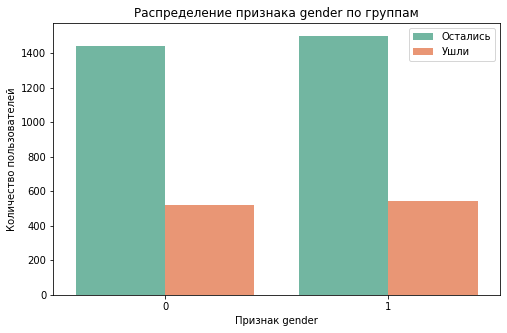

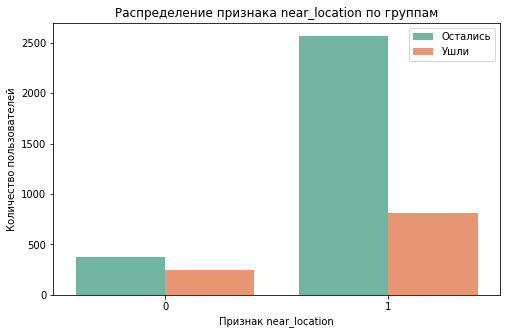

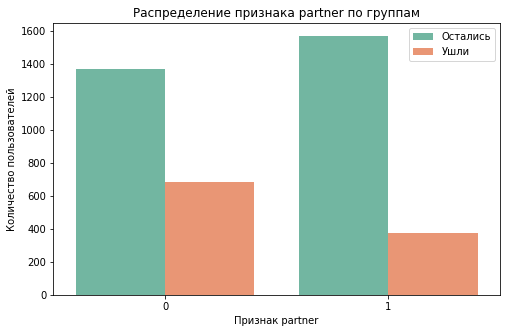

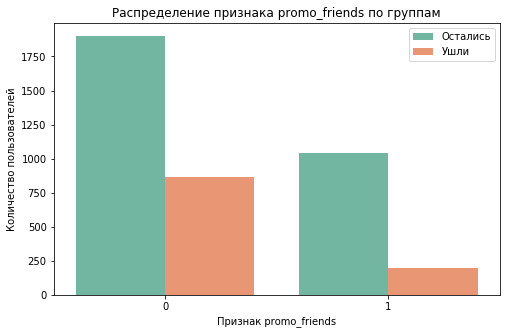

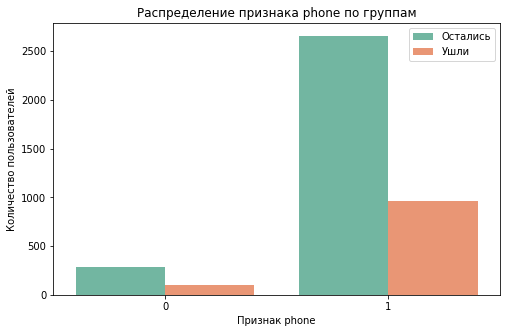

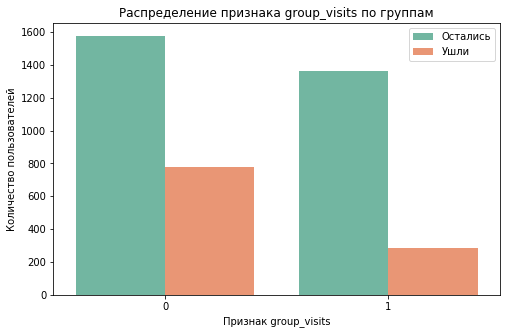

In [19]:
for attribute in binary_attributes:
    plt.figure(figsize=(8,5))
    sns.countplot(x=attribute, hue='churn', palette="Set2", data=gym)
    plt.title('Распределение признака {} по группам'. format(attribute))
    plt.legend(['Остались','Ушли'])
    plt.xlabel('Признак {}'. format(attribute))
    plt.ylabel('Количество пользователей');

Большинство посетителей живут или работают рядом с фитнес-центром и у них есть телефон. По всем бинарным признакам отток клиентов составляет существенную часть от оставшихся пользователей. На графике признака `near_location` видно, что удаленность от фитнес-центра сильно влияет на желание пользователя туда ходить: более половины от оставшихся клиентов перестали посещать заведение.

Посмотрим теперь на распределение небинарных признаков по группе отттока и группе оставшихся пользователей

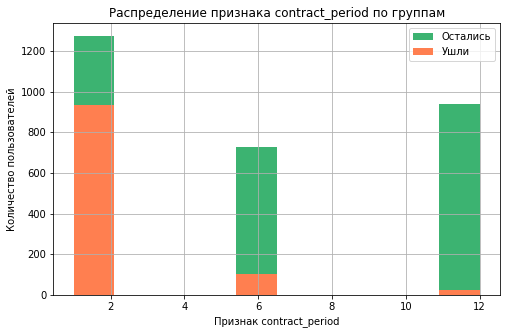

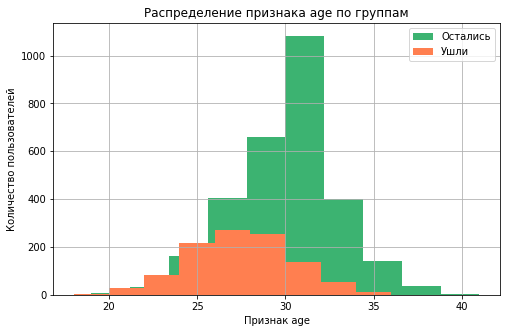

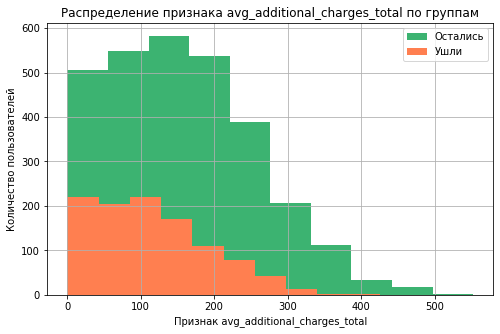

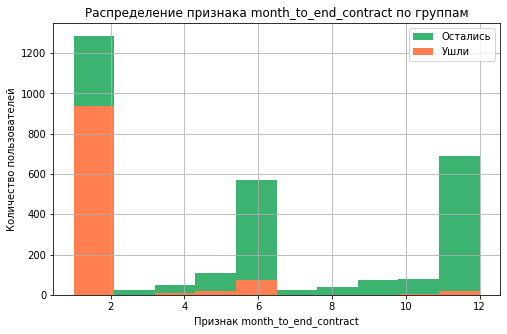

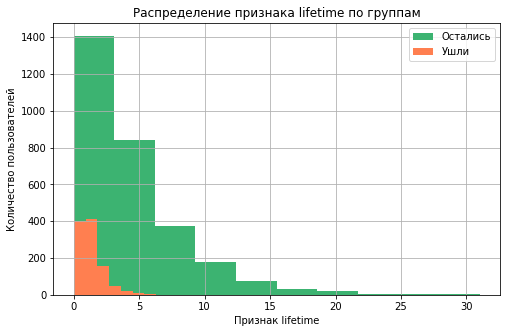

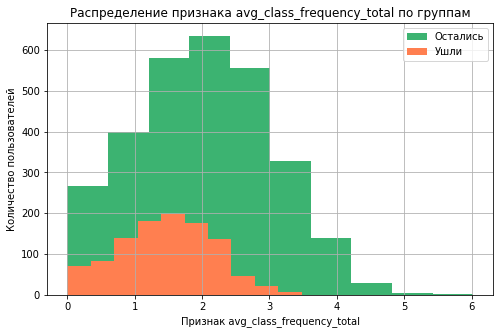

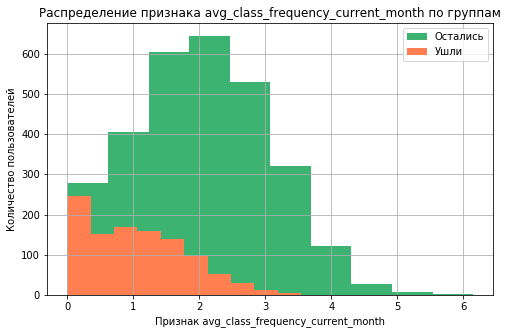

In [20]:
for attribute in not_binary_attributes:
    plt.figure(figsize=(8,5))
    gym.query('churn == 0')[attribute].hist(color='mediumseagreen')
    gym.query('churn == 1')[attribute].hist(color='coral')
    plt.title('Распределение признака {} по группам'. format(attribute))
    plt.legend(['Остались','Ушли'])
    plt.xlabel('Признак {}'. format(attribute))
    plt.ylabel('Количество пользователей');

Чем длительнее период действия абонемента - тем меньше отток пользователей. Клиенты, у которых годовой абонемент, ценят свои финансовые вложения и регулярно ходят в фитнес-центр. С приближением срока окончания абонемента, пользователи перестают экономить и большинство из них бросает занятия спортом

Построим матрицу корреляций признаков и отобразим ее

In [21]:
gym.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


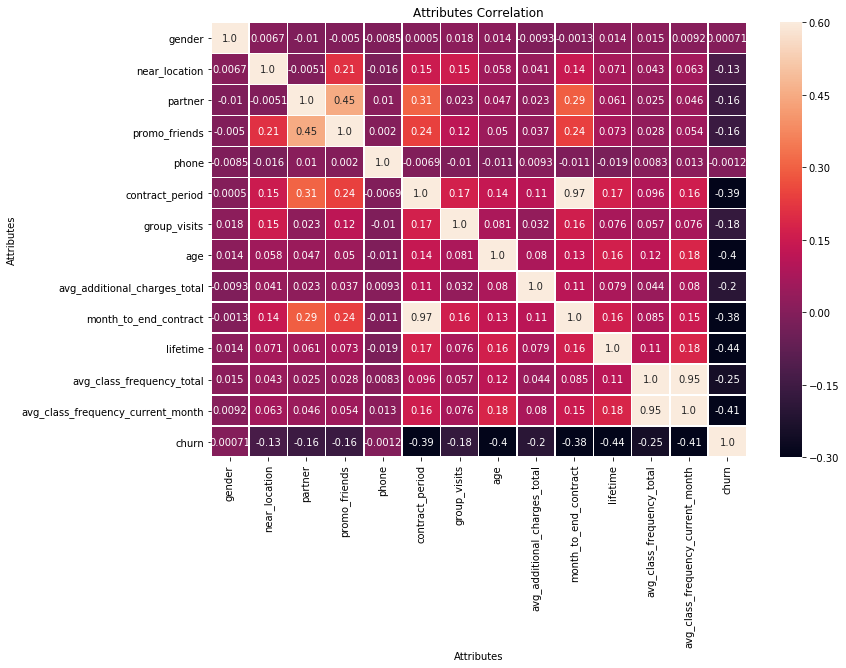

In [22]:
plt.figure(figsize=(12,8))
plt.title('Attributes Correlation')
sns.heatmap(gym.corr(), annot=True, fmt='.2', linewidths=0.5, linecolor='white', vmin=-0.3, vmax=0.6)
plt.ylabel('Attributes')
plt.xlabel('Attributes');

Почти стороцентная корреляция наблюдается у признаков-близнецов, например `month_to_end_contract` и  `contract_period`, или `avg_class_frequency_current_month` и `avg_class_frequency_total`. Большинство признаков никак не связано между собой. Исключение - положительная корреляция 0.45 признаков `promo_friends` и `partner`.   
На отток пользователей (с отрицательной корреляцией 0,4) влияют длительность абонемента, возраст пользователя, время с его первого обращения и число посещений фитнес-центра в неделю: чем ниже эти показатели, тем выше отток пользователей

Удалим по одному признаку из пары признаков-близнецов:
    
- `month_to_end_contract` и `contract_period`
    
- `avg_class_frequency_current_month` и `avg_class_frequency_total`,
    
чтобы они не мешали в дальнейшем при обучении модели прогнозирования оттока пользователей

In [23]:
gym = gym.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)

### Вывод      

Привели названия столбцов к единому регистру.
    
Составили портрет среднестатистического клиента в целом, а так же с разбивкой на группы: тех, кто ушел в отток и тех, кто остался. Во всех случаях среднестатистический клиент одинаково может быть как мужчиной, так и женщиной, и в среднем в 85% случаев он проживает / работает рядом с фитнес-центром. У среднестатистического клиента почти всегда есть телефон, а длительность его абонемента один месяц. Он скорее не посещает групповые занятия в фитнес-центре, чем посещает (60% против 40%). И для принятия решения записаться в зал ему потребовалось три месяца, чтобы потом, в одном случае из четырех, бросить ходить.
    
Суммарная выручка от дополнительных услуг фитнес-центра на одного клиента в среднем составляет 147 рублей. Если посмотреть на суммарную выручку с разбивкой клиентов на группы, видно, что ушли более прижимистые пользователи. В среднем выручка фитнес-центра от оставшегося клиента составляет 158 рублей против 115 рублей от ушедшего. Оставшиеся пользователи могут потратить максимально 553 рубля против 425 рублей тех, кто больше не вернется.
    
Средняя частота посещений фитнес-центра одним посетителем за весь период действия абонемента составляет 1,8 раз в неделю. Разница в средней частоте посещения фитнес-центра между теми, кто остался и теми, кто ушел в отток, очевидна: 2 раза в неделю против 1,5 раз в неделю за весь период действия абонемента и 2 раза в неделю против 1 раза в неделю за прошлый месяц.
    
На графике признака `near_location` видно, что удаленность от фитнес-центра сильно влияет на желание пользователя туда ходить: более половины от оставшихся клиентов перестали посещать заведение. Чем длительнее период действия абонемента - тем меньше отток пользователей. Клиенты, у которых годовой абонемент, ценят свои финансовые вложения и регулярно ходят в фитнес-центр. С приближением срока окончания абонемента, пользователи перестают экономить и большинство из них бросает занятия спортом.
    
Большинство признаков никак не связано между собой. Почти стороцентная корреляция наблюдалась у пар признаков `month_to_end_contract` - `contract_period`, и `avg_class_frequency_current_month` - `avg_class_frequency_total`. Чтобы скоррелированные признаки не мешали при обучении модели, мы удалили по одному из каждой пары

## 3. Построим модель прогнозирования оттока пользователей <a name="model"></a>          
[*назад к оглавлению*](#0-bullet)     🚀

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце.    
Разобъем данные на обучающую и валидационную выборки функцией train_test_split()

In [24]:
X = gym.drop('churn', axis = 1)
y = gym['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Обучим модель на train-выборке логистической регрессией

In [25]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

Обучим модель на train-выборке случайным лесом

In [26]:
rf_model = RandomForestClassifier(n_estimators = 40, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

Рассчитаем метрики `accuracy`, `precision` и `recall` для обеих моделей на test-выборке. Сравним по ним модели 

In [27]:
def metrics(y_true, y_pred, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [28]:
metrics(y_test, lr_predictions, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.83
	Recall: 0.80


In [29]:
metrics(y_test, rf_predictions, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.75


Обе модели показывают высокую точность предсказаний. Модель логистической регресии дает чуть более точные значения по всем метрикам по сравнению с моделью случайного леса 

### Вывод   

Мы построили модель прогнозирования оттока пользователей, и обучили ее двумя способами: логистической регрессией и случайным лесом. Для обеих моделей на валидационной выборке были рассчитаны метрики `accuracy`, `precision` и `recall`.    
Обе модели показали высокую точность предсказаний. Модель логистической регресии дает чуть более точные значения по всем метрикам по сравнению с моделью случайного леса. По-видимому, для прогнозирования данных небольшого размера наиболее точно подходит модель логистической регрессии

## 4. Проведем кластеризацию пользователей <a name="cluster"></a>          
[*назад к оглавлению*](#0-bullet)     🚀

Стандартизируем данные

In [30]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Построим матрицу расстояний и отобразим ее на дендрограмме

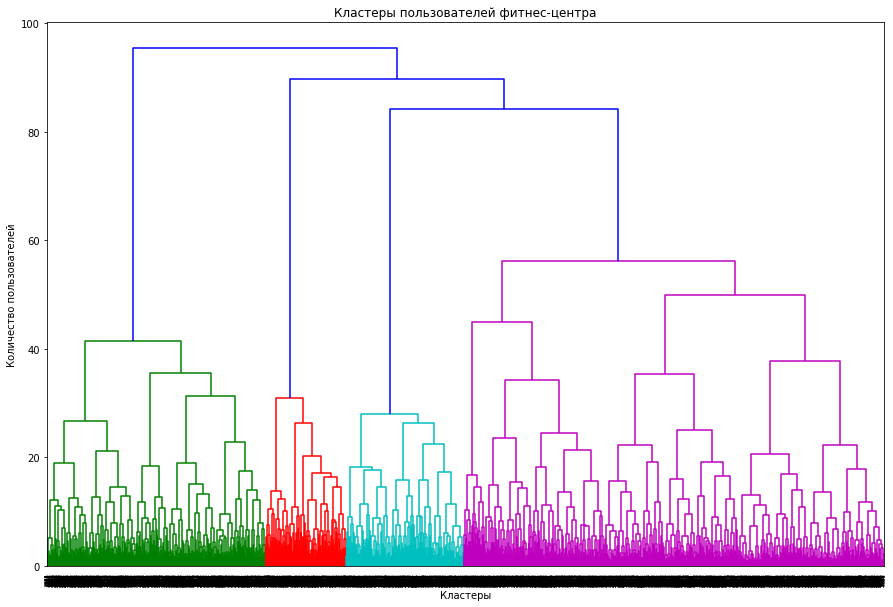

In [31]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеры пользователей фитнес-центра')
plt.ylabel('Количество пользователей')
plt.xlabel('Кластеры')
plt.show();

Предложенное оптимальное число кластеров 4 — четыре разных цвета на дендрограмме

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры пользователей. Возьмем за число кластеров `n`= 5,  несмотря на обраруженные дендрограммой 4 кластера, так как данная рекомендация присутствует в ТЗ 

In [32]:
km = KMeans(n_clusters = 5, random_state = 42) 
labels = km.fit_predict(X_sc) 

Посмотрим на средние значения признаков для кластеров

In [33]:
gym['cluster'] = labels
gym.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,,
0,0.503986,1.000000,0.234721,0.062002,1.0,2.795394,0.000000,28.761736,143.366166,3.311780,1.798457,0.382640
1,0.496056,0.995618,0.960561,0.818580,1.0,8.007011,0.498685,29.606486,154.944436,4.361963,1.974414,0.113059
2,0.541507,1.000000,0.166028,0.088123,1.0,3.688378,1.000000,29.453384,148.529509,3.761175,1.946217,0.220945
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839
4,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287


Сразу можно заметить, что в кластере под номером 1, с самым высоким средним значением длительности абонемента 8 месяцев, самый низкий показатель оттока пользователей 11%, что уже было отмечено нами ранее. А кластеры под номерами 4 и 0, с самыми высокими показателями оттока пользователей 40% и 38% соответственно, наоборот отличаются самыми низкими средними показателями длительности абонемента - 3 месяца.   
Средние показатели распределения признаков по полу и возрасту посетителей среди кластеров примерно одинаковые

Построим распределения бинарных признаков и признака `contract_period` для кластеров 

In [34]:
binary_attribute = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']
not_binary_attribute = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']

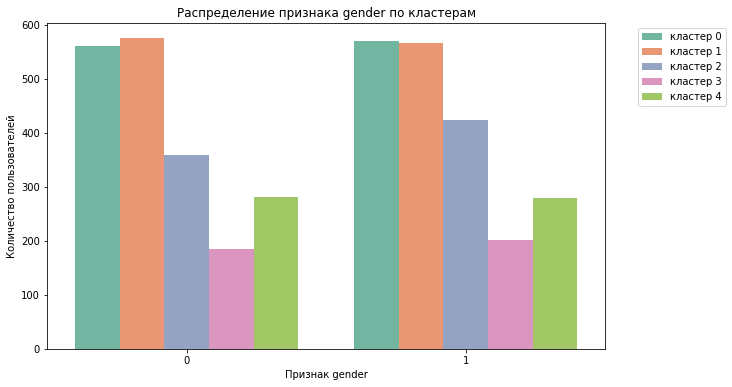

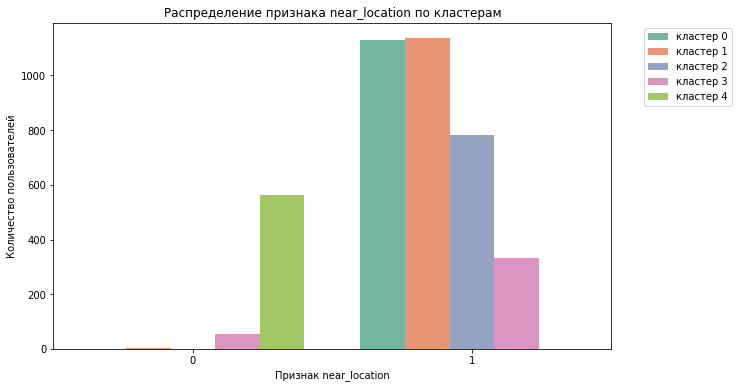

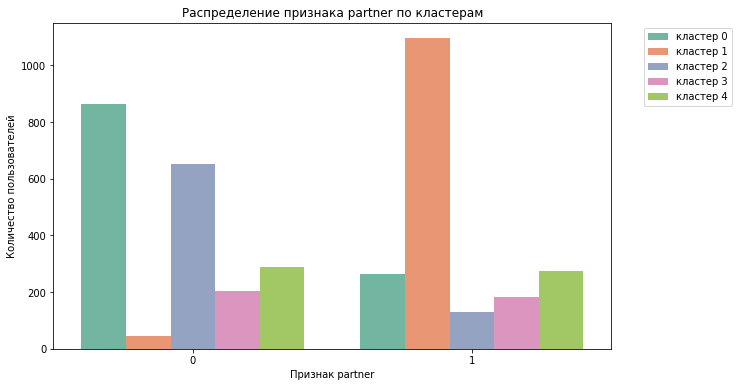

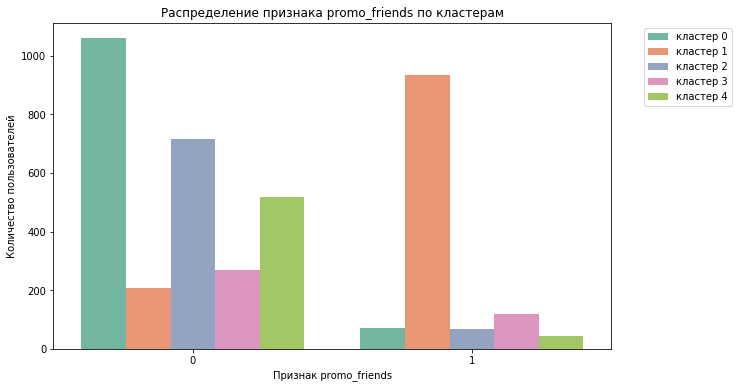

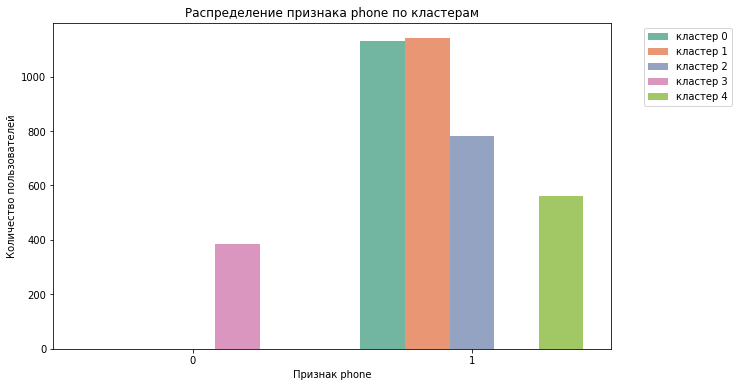

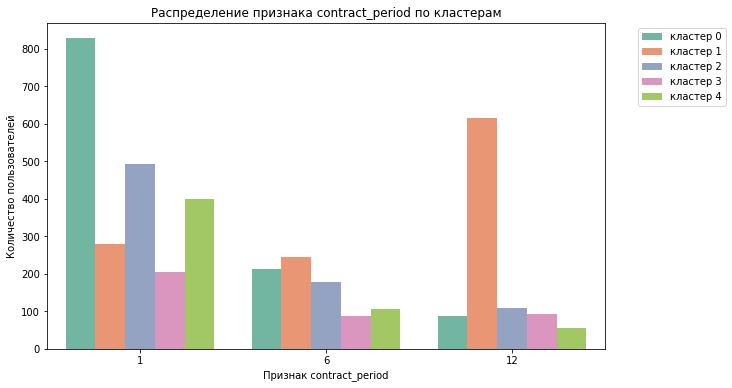

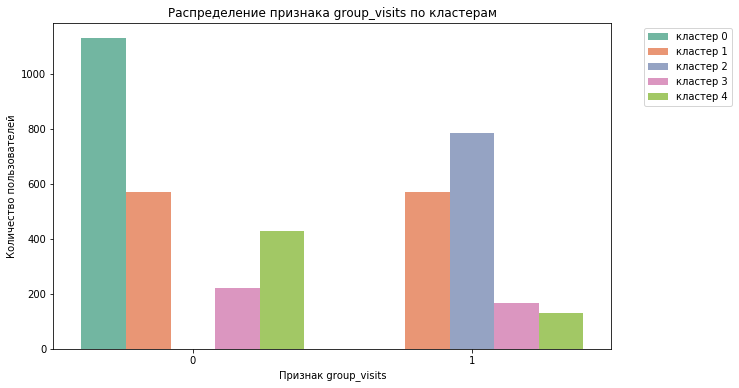

In [35]:
for attribute in binary_attribute:
    plt.figure(figsize=(10,6))
    sns.countplot(x=attribute, hue='cluster', palette="Set2", data=gym)
    plt.title('Распределение признака {} по кластерам'. format(attribute))
    plt.legend(['кластер 0','кластер 1', 'кластер 2', 'кластер 3', 'кластер 4'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Признак {}'. format(attribute))
    plt.ylabel('Количество пользователей');

Наиболее равномерно распределенный признак по всем кластерам - `gender`. Признак `phone` выделяет кластер 3 от остальных - у его посетителей нет телефона. По признаку `near location` выделяется кластер 4, теперь понятно, почему его посетители перестают ходить в фитнес-центр: они живут или работают вдали от фитнес-центра. У кластера 1, с наименьшим оттоком посетителей, максимальное количество абонементов длительностью 12 месяцев и максимальное количество сотрудников фирм-партнеров фитнес-центра 

Построим распределения непрерывных признаков для кластеров 

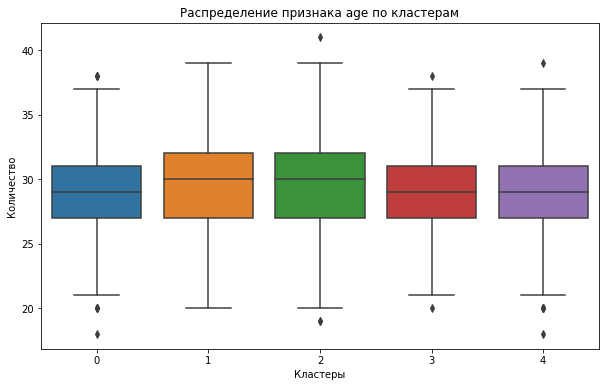

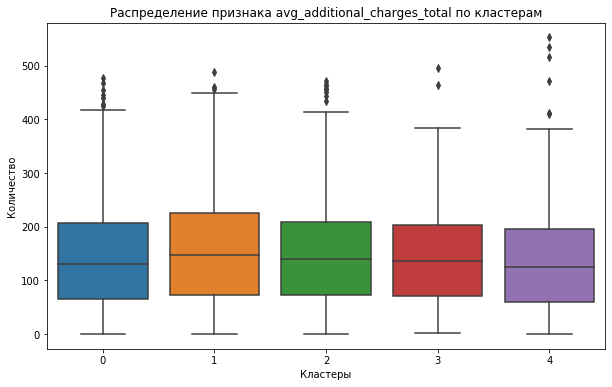

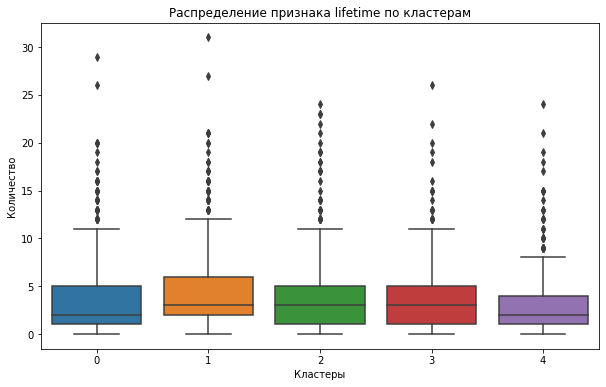

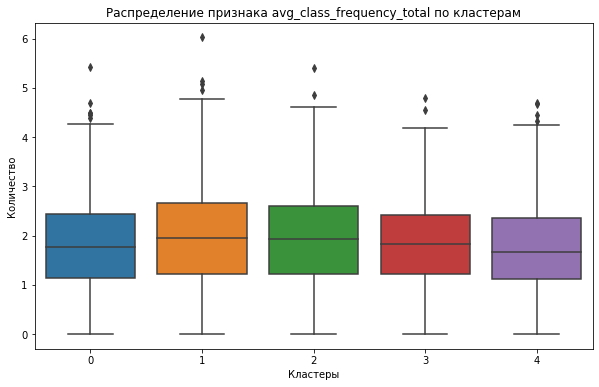

In [36]:
for attribute in not_binary_attribute:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='cluster', y=attribute, data=gym)
    plt.title('Распределение признака {} по кластерам'. format(attribute))
    plt.xlabel('Кластеры')
    plt.ylabel('Количество');

Самый надежный кластер 1 обладает наиболее взрослыми посетителями: медиана возраста - 30 лет. Его посетители тратят больше всех на дополнительные услуги фитнес-центра. Так же посетители из кластеров 1 и 2 чаще остальных посещают зал: в среднем два раза в неделю. Кластеры 0 и 4 с наиболее молодыми пользователями характеризуются минимальными тратами на дополнительные услуги фитнес-центра и самым коротким показателем `lifetime`. Как видим, молодежь быстрее всех принимает решения, в т.ч. и о записи в фитнес-центр, правда потом с той же скоростью меняет их

Посчитаем и визуализируем долю оттока для каждого кластера

In [37]:
churn = gym.pivot_table(index='cluster', values='churn').reset_index()
churn

,cluster,churn
0,0,0.382640
1,1,0.113059
2,2,0.220945
3,3,0.266839
4,4,0.399287


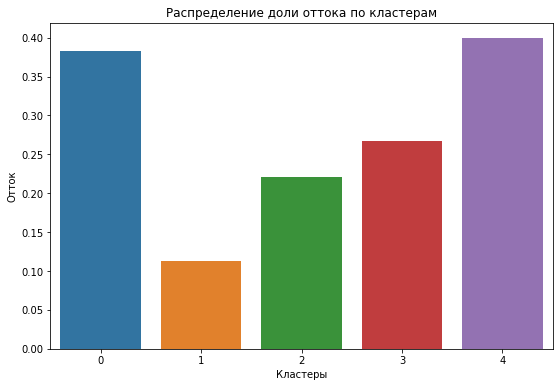

In [38]:
plt.figure(figsize=(9,6))
sns.barplot(x='cluster', y='churn', data=churn)
plt.title('Распределение доли оттока по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Отток');

Кластер 1 обладает самой низкой долей оттока пользователей - 11%. Все дело в том, что здесь собрались клиенты фитнес-центра с наиболее длительным сроком абонемента, то есть с наибольшими инвестициями. Поэтому логично, что никто не разбрасывается финансами и не перестает ходить в зал.
    
Кластер 2, который объединяет самых активных пользователей фитнес-центра, тоже довольно надежный кластер - доля оттока 22%. 
    
Кластер 3 состоит из достаточно лояльных пользователей и обладает долей оттока чуть менее 27%.
    
Кластеры 0 и 4 состоят из наиболее молодых пользователей с минимальным сроком длительности абонемента. Отсутствие финансового якоря позволяет им легко отказываться от услуг фитнес-центра. Именно поэтому у кластеров 0 и 4 самая высокая доля оттока пользователей - 38% и 40%

## 5. Вывод <a name="output"></a>       
[*назад к оглавлению*](#0-bullet)     🚀

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Перед нами стояла задача — провести анализ и подготовить план действий по удержанию клиентов.      

В данных 4000 записей, пропуски и категориальные переменные отсутствуют. Названия столбцов были приведены к единому регистру. В текущем месяце в отток попал 1061 клиент. Более 26% посетителей фитнес-центра перестали пользоваться его услугами. Если не улучшить стратегию поведения в будущем, через месяц фитнес-центр потеряет уже более половины клиентов, обслуживающихся на данный момент.     

Суммарная выручка от сопутствующих услуг фитнес-центра на одного клиента в среднем составляет 147 рублей, медианное значение 136 рублей. Максимальный показатель суммарной выручки 553 рубля. Если посмотреть на суммарную выручку с разбивкой клиентов на группы - тех, кто ушел и тех, кто остался, видно, что ушли более прижимистые пользователи. В среднем выручка фитнес-центра от оставшегося клиента составляет 158 рублей против 115 рублей от ушедшего. Оставшиеся пользователи могут потратить максимально 553 рубля против 425 рублей тех, кто больше не вернется.      
Средняя частота посещений фитнес-центра одним посетителем за весь период действия абонемента составляет 1,8 раз в неделю. Самые увлеченные посетители занимаются спортом 6 раз в неделю. Тот же показатель частоты посещений фитнес-центра, но только за прошлый месяц, чуть меньше - 1,7 раз в неделю. А максимальное значение посещений, наоборот, чуть выше - 6,1 раз в неделю.      
Разница в средней частоте посещения фитнес-центра между теми, кто остался и теми, кто ушел в отток, очевидна: 2 раза в неделю против 1,5 раз в неделю за весь период действия абонемента и 2 раза в неделю против 1 раза в неделю за прошлый месяц. Но более убедительная разница у показателей максимального количества посещений: 6 раз в неделю у оставшихся любителей спорта против 3,5 раз в неделю у ушедших.      

Большинство посетителей живут или работают рядом с фитнес-центром и у них есть телефон. По всем бинарным признакам отток составляет существенную часть от оставшихся клиентов. Удаленность от фитнес-центра негативно влияет на желание посетителей туда ходить.      
Чем длительнее период действия абонемента - тем меньше отток посетителей. Клиенты, у которых годовой абонемент, ценят свои финансовые вложения и регулярно ходят в фитнес-центр. С приближением срока окончания абонемента, посетители перестают экономить и большинство из них бросает занятия спортом.       
Почти стороцентная корреляция наблюдается у признаков-близнецов: `month_to_end_contract` - `contract_period`, и `avg_class_frequency_current_month` - `avg_class_frequency_total`. Большинство признаков никак не связано между собой. На отток посетителей влияют длительность абонемента, возраст, время с его первого обращения и число посещений фитнес-центра в неделю: чем ниже эти показатели, тем выше отток.      

Мы построили модель прогнозирования оттока посетителей и обучили ее двумя способами: логистической регрессией и случайным лесом. Для обеих моделей на валидационной выборке были рассчитаны метрики `Accuracy`, `Precision` и `Recall`.   
Метрики для модели логистической регрессии:   
- Accuracy: 0.90   
- Precision: 0.83   
- Recall: 0.80       

Обе модели показали высокую точность предсказаний. Однако модель логистической регресии дает чуть более точные значения по всем метрикам по сравнению с моделью случайного леса, поскольку для прогнозирования данных небольшого размера подходит наиболее точно.      
  
На дендрограмме матрице расстояний было предложено оптимальное число кластеров - 4 кластера. Для обучения модели кластеризации на основании алгоритма K-Means было взято число кластеров n= 5: от кластера 0 до кластера 4.      
В кластере 1, с самым высоким средним значением длительности абонемента 8 месяцев, самый низкий показатель оттока пользователей - 11%. Кластер 1 - самый надежный кластер. Это объясняется тем, что здесь собрались более взрослые клиенты фитнес-центра с наиболее длительным сроком абонемента, то есть, с наибольшими инвестициями. Поэтому логично, что никто не разбрасывается финансами и не перестает ходить в зал. Кластер 2, который объединяет самых активных пользователей фитнес-центра, тоже довольно надежный кластер - доля оттока 22%. А кластеры 0 и 4, с самыми высокими показателями оттока пользователей 38% и 40%, наоборот отличаются более молодыми пользователями с наименьшими показателями длительности абонемента - 3 месяца.     

Средние показатели распределения по полу и возрасту посетителей среди кластеров примерно одинаковые.      
Кластеры 0 и 4 с наиболее молодыми пользователями характеризуется самой короткой длительностью абонемента и самым коротким сроком принятия решений `lifetime`. Как оказалось, молодежь быстрее всех принимает решения, в т.ч. и о записи в фитнес-центр, правда потом с той же скоростью меняет их. Кластеры 1 и 2 объединяют пользователей, которые ходят в фитнес-центр чаще остальных - в среднем 2 раза в неделю.      

В результате проведенного анализа обнаружены основные признаки, наиболее сильно влияющие на отток:   
- удаленность проживания или места работы пользователя от фитнес-центра   
- длительность приобретаемого пользователем абонемента    
- наличие у него телефона       
- является ли пользователь сотрудником компании-партнера клуба    
- скорость принятия решения о покупке абонемента.   

Для повышения качества работы с клиентами сети фитнес-центров "Культурист-датасаетнист" можно рекомендовать:   
- оптимизировать линейку предлагаемых абонементов по длительности: отказаться от абонементов с коротким сроком действия   
- сосредоточиться на пользователях, проживающих или работающих вблизи фитнес-центров   
- разработать систему бонусов для потенциальных клиентов старше 30 лет   
- разработать программу лояльности для действующих пользователей, кто посещает фитнес центр два и более раза в неделю.   